In [1]:
import pandas as pd

In [2]:
col = pd.read_csv('gifts_cleared_by_hands.tsv')

In [3]:
description_columns = col.columns[col.columns.str.contains('self_gift_desc_')]

# DBSCAN

In [4]:
from sklearn.cluster import DBSCAN
clustering = DBSCAN(eps=1.7, min_samples=20).fit(pd.get_dummies(col[description_columns].astype(str)))


In [5]:
labels = pd.Series(clustering.labels_)
labels.unique()

array([-1,  0,  1,  2])

In [6]:
col.self_gift_name_cleared[labels==2]

197                                      массажер
277                                        миксер
349                                          игра
374                                      массажер
379                                        чайник
402                              кухонный комбайн
465                                плед с принтом
491                              банное полотенце
544                              торцовочная пила
576                                       триммер
579                             электроинструмент
598    форма для запекания из жаропрочного стекла
603                                  банный халат
665                           акустическая гитара
670                            набор инструментов
764                         выпрямитель для волос
784                           кофеварочная машина
786                                         чашка
814                                       кошелек
842                                        посуда


Отделил телефоны и духи от всего остального

# Affinity propagation

In [7]:
from sklearn.cluster import AffinityPropagation
clustering = AffinityPropagation(damping=0.977).fit(pd.get_dummies(col[description_columns].astype(str)))


In [8]:
pd.Series(clustering.labels_).groupby(clustering.labels_).size()

0     14
1      6
2     23
3      4
4     19
5     29
6     68
7     22
8      6
9     27
10    73
11     8
12     3
13    26
14     5
15    61
16    17
17    12
18    12
19    22
20    17
21    11
22    21
23    24
24    14
25     4
26    50
27     6
28    10
29     9
30     5
31    25
32    20
33    19
34     4
35    10
36    13
37    21
38    35
39    32
40    22
41    16
42    27
43     5
44    21
45    10
46     5
47    23
48     8
49     7
50     2
51     3
dtype: int64

In [9]:
labels = pd.Series(clustering.labels_)
labels.unique()

array([15, 41, 26, 32,  2, 20, 22, 38,  6, 18, 39,  0, 23,  1, 47, 10,  4,
        3, 36, 42, 29, 11, 40, 16,  5, 45, 13, 17, 37,  7, 19, 28, 31, 33,
       27, 46,  9, 24, 25,  8, 50, 12, 44, 21, 14, 49, 43, 48, 35, 34, 30,
       51])

In [10]:
col.self_gift_name_cleared[labels==labels.unique()[7]]

7                             гимнастическая гиря
54                                набор "доктора"
166                                   гидрокостюм
191                           кофеварочная машина
197                                      массажер
200                                спальный мешок
263                                         книга
277                                        миксер
290                                        удочка
345                                        рюкзак
349                                          игра
374                                      массажер
379                                        чайник
402                              кухонный комбайн
465                                плед с принтом
489                    страйкбольный привод ак105
491                              банное полотенце
531                                        удочка
544                              торцовочная пила
571                              паяльная станция


# AgglomerativeClustering

In [11]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=10).fit(pd.get_dummies(col[description_columns].astype(str)))


In [12]:
pd.Series(clustering.labels_).groupby(clustering.labels_).size()

0    101
1    193
2    115
3     90
4     76
5     96
6     84
7     85
8     58
9     58
dtype: int64

In [13]:
labels = pd.Series(clustering.labels_)
labels.unique()

array([9, 2, 1, 6, 0, 8, 5, 7, 4, 3])

In [14]:
col.self_gift_name_cleared[labels==labels.unique()[6]]

12                                             мясорубка
13                                         gps навигатор
14                                           зимние шины
19                                             кофемолка
23                                                  плед
27                                              мотоблок
36                           набор ключей для автомобиля
40                                                 ручка
44                                               картина
55                                               телефон
58                               проигрыватель пластинок
61                                   набор для рисования
86     персональное видео поздравление от известного ...
102                                     кухонный комбайн
121                                         набор посуды
125                                                книга
137                                             эпилятор
144                            

# Checking advices with clustering

In [15]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, LabelBinarizer

def get_data(x):
    data = x.copy()
    # dropping text features (but not gift description)
    text_like = ['OUTPUT:person_character_word', 'OUTPUT:person_appearance_word', 'OUTPUT:person_description_text',
            'OUTPUT:person_communication_word', 'OUTPUT:person_individuality_word', 'OUTPUT:self_gift_link',]

    # dataframe with text fields
    # we'll use it later
    tdata = data[text_like]
    tdata = tdata.drop('OUTPUT:self_gift_link', axis=1)

    data = data.drop(text_like, axis=1) #at the start we do not really need it

    #gift description drop
    data = data.drop(['OUTPUT:self_gift_name', 'Unnamed: 0'], axis=1)
    
    additional_drops = ['OUTPUT:self_gift_mark', 'OUTPUT:self_variants', 'OUTPUT:self_gift_times', 'OUTPUT:self_gift_usage',
                    'OUTPUT:self_gift_bad_usage', 'self_gift_name_cleared', 'OUTPUT:self_time']
    data = data.drop(additional_drops, axis=1)

    
    Y = data['OUTPUT:self_gift_mark_2']
    X = data.drop('OUTPUT:self_gift_mark_2', axis=1) 

    leave = ['OUTPUT:person_age', 'OUTPUT:self_age']
    to_onehot = X.drop(['OUTPUT:person_age', 'OUTPUT:self_age'], axis=1).columns.values

    onehotencoded = pd.get_dummies(X[to_onehot].astype(str))

    to_binarize = []

    def binarize_column(data , column):
        un = data[column].unique()
        un_dict = {v:k for k, v in enumerate(un)}
        data[column] = data[column].apply(lambda x: un_dict[x])

    def binarize_set(data):
        for col in data.columns:
            binarize_column(data, col)

    binarized = data[to_binarize].copy()
    binarize_set(binarized)
    
    X_encoded = pd.concat([onehotencoded, X[leave]], axis=1)
    return X_encoded, Y, tdata

In [16]:
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
import operator
import pymorphy2
import gensim
import nltk

def return_thematic_features(model, doc_set):
    tokenizer = RegexpTokenizer(r'\w+')

    ru_stop = stopwords.words('russian')

    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    
    morph = pymorphy2.MorphAnalyzer()
    # list for tokenized documents in loop
    texts = []
    token_counts = {}
    sum_counts = 0
    docs_tokens = []
    # loop through document list
    for idx in range(len(doc_set)):
        # clean and tokenize document string
        raw = doc_set[idx].lower()
        tokens = tokenizer.tokenize(raw)
        # уборка частых слов уже после токенизации осознанна
        for elem in tokens:
            if elem in token_counts:
                token_counts[elem] += 1
            else:
                token_counts[elem] = 1
            sum_counts += 1
        docs_tokens.append(tokens)

    sorted_counts = sorted(token_counts.items(), key=operator.itemgetter(1))
    #sorted_counts.reverse()

    summator = 0
    sum_counts_fl = float(sum_counts)
    for idx in range(len(sorted_counts)):
        if summator / sum_counts_fl < float(0.4): # отсеиваемая доля
            summator += sorted_counts[idx][1]
            ru_stop.append(sorted_counts[idx][0])
        else:
            break 

    for idx in range(len(doc_set)):
        tokens = docs_tokens[idx]
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in ru_stop]
        # stem tokens
        #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]

        # add tokens to list
        texts.append(stopped_tokens)
        
    normalized_texts = []
    for elem in texts:
        new = []
        for w in elem:
            p = morph.parse(w)[0]
            new.append(p.normal_form)
        normalized_texts.append(new)
        
    features = []
    for text in texts:
        answ = dict()
        for i in range(model.num_topics):
            answ['thematic_'+str(i)] = 0.0
        dictionary = model.id2word
        pred = dictionary.doc2bow(text)
        for elem in model[pred]:
            answ['thematic_'+str(elem[0])] = float(elem[1])
        features.append(answ)
    return features

def get_prepared_train(X, tdata):
    res = []
    for idx, row in tdata.iterrows():
        s = ""
        for col in tdata.columns:
            s += row[col].lower() + ' '
        s = s.replace(',', '')
        s = s.replace('  ', '')
        res.append(s)
    m = gensim.models.LdaModel.load("10/results.model")
    thematic_features = return_thematic_features(m, res)
    tdata_features = pd.DataFrame(thematic_features)
    
    return pd.concat([X.reset_index(drop=True), tdata_features.reset_index()], axis=1)

In [17]:
from sklearn.ensemble import RandomForestRegressor
def get_model(X, Y):
    theme_regressor = RandomForestRegressor(random_state=42, max_depth=3, n_estimators=22)
    theme_regressor.fit(X, Y)
    return theme_regressor

/home/nexxof/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [20]:
# check if function is working
import random
pool_building = pd.read_csv('gifts_cleared_by_hands.tsv')
pool =  pool_building['self_gift_name_cleared']

description_columns = train.columns[train.columns.str.contains('self_gift_desc_')]


descriptions_from_pool = train[description_columns].drop_duplicates()
def get_samples(pool, dataset, description, descr_columns):
    condition = [True for i in range(len(dataset))]
    for desc, col in zip(description, descr_columns):
        condition = condition & (dataset[col]==desc)
        
    return pool[condition].values[0]
        

def rate_descriptions(model, descriptions_from_pool, person_description, description_columns):
    '''
    Person description must contain columns for present descriptions 'cause I'm lazy bastard
    '''
    rated = descriptions_from_pool.copy()
    rated['rating'] = [0 for i in range(len(rated))]
    for x in descriptions_from_pool.iterrows():
        description = x[1].values
        current_sample = person_description.copy()
        current_sample[description_columns] = description
        
        prediction = model.predict([current_sample.values])
        
        rated.loc[x[0], 'rating'] = prediction
        
    return rated

def get_proposals(model, dataset, person_description, description_columns, pool, labels):
    rating = rate_descriptions(model,  dataset[description_columns], person_description, description_columns)
    rating = pd.concat([rating, pd.DataFrame(labels, columns = ['cluster'])], axis=1)
    rating = rating.sort_values('rating', ascending=False).reset_index()
    
    proposals = []
    
    for label in labels.unique():
        r = random.randint(0, 5)
        top_from_cluster = rating[rating.cluster == label].reset_index(drop=True).iloc[r]
        score = top_from_cluster.rating
        top_from_cluster = top_from_cluster.drop(labels=['rating']).values[1:]
        
        proposals.append(get_samples(pool,
                                     dataset,
                                     top_from_cluster,
                                     description_columns))
        print (proposals[-1], score)
    
    #for sample in rating.iloc[:10].iterrows():
    #    proposals.append(get_samples(pool,
    #                                 dataset,
    #                                 sample[1].drop(labels=['rating']).values[1:],
    #                                 description_columns))
        
    return rating.rating#list(set(map(lambda x: x.lower(), proposals)))

In [54]:
old_X, old_Y, old_tdata = get_data(col)
old_train = get_prepared_train(old_X, old_tdata)
old_model = get_model(old_train, old_Y)

In [56]:
r=get_proposals(old_model, old_train, old_train.iloc[100], description_columns, pool, labels)

наушники 85.46240241827827
набор для бритья 85.46240241827827
конструктор 85.82386453346354
телефон 85.82386453346354
украшение 85.46240241827827
мыло ручной работы 85.82386453346354
телефон 85.82386453346354
телефон 81.12778194501665
украшение 85.82386453346354
набор для бритья 85.46240241827827


In [44]:
def oversample_train(X, Y, pool):
    temp = pd.concat([X, pd.DataFrame(list(zip(Y,pool)), columns=['target', 'gift'])],axis=1)
    result = []
    for gift in temp.gift.unique():
        to_sample = temp[temp.gift==gift]
        if len(to_sample)<10:
            result.append(pd.concat([to_sample for i in range(int(10/len(to_sample)))]))
        else:
            result.append(to_sample)
    concatenated = pd.concat(result)
    pool = concatenated.gift
    Y= concatenated.target
    return concatenated.drop(['target', 'gift'], axis=1), Y, pool

In [60]:
train, Y, pool = oversample_train(old_train, old_Y, pool)
model = get_model(train, Y)

In [61]:
r= get_proposals(model, old_train, old_train.iloc[180], description_columns, pool, labels)

набор для бритья 84.42950488374976
набор для бритья 87.3586005031901
конструктор 87.72006261837537
телефон 87.72006261837537
гимнастическая гиря 87.3586005031901
набор для ванной 87.72006261837537
мыло ручной работы 87.3586005031901
мыло ручной работы 87.72006261837537
конструктор 87.72006261837537
телефон 87.72006261837537


In [62]:
model.feature_importances_

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 5.25790798e-03, 6.18452903e-03,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 6.24904088e-03, 3.80669957e-03, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.39834217e-02, 8.15956271e-03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

# Model Selection

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
import numpy as np
def perform_n_cv(clf, x, y, cv_count, scoring, iterations):
    cv_accumulator = []
    for i in range(iterations):
        cv = cross_val_score(clf, x, y, cv=cv_count, scoring=scoring)
        cv_accumulator.append([np.mean(np.sqrt(cv)), np.std(np.sqrt(cv))])
        
    return np.mean(np.array(cv_accumulator)[:, 0]), np.mean(np.array(cv_accumulator)[:, 1])

def score_params(*data, model, param_grid):
    X, Y = data
    rfr=model#Lasso(random_state=42)

    

    CV_rfc = GridSearchCV(estimator=rfr, param_grid=param_grid, cv= 10)
    CV_rfc.fit(X, Y)

    print (CV_rfc.best_params_)
    rfr=model#Lasso(random_state=42)
    rfr.set_params(**CV_rfc.best_params_)
    mean, std = perform_n_cv(rfr, X, Y, cv_count=10, scoring=make_scorer(mean_squared_error), iterations=1)
    print (mean, '+-' ,std)

In [24]:
from sklearn.linear_model import Lasso, Ridge
score_params(train, Y, model=Ridge(random_state=42),
             param_grid = {'alpha': [0.01, 0.1, 1, 10, 20, 50, 100, 500, 1000]})

{'alpha': 1000}
26.085249446213517 +- 3.5666309502277995


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

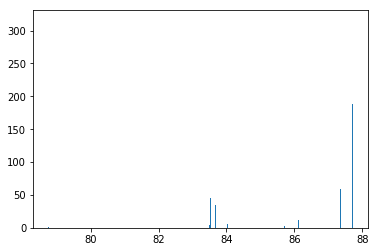

In [63]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline  
plt.hist(r, bins=500)